In [29]:
%matplotlib inline
import math, numpy as np, tensorflow as tf, matplotlib.pyplot as plt, operator
from importlib import reload

# Clustering

In [30]:
import kmeans; reload(kmeans)
from kmeans import Kmeans

In [31]:
n_clusters=6
n_samples =250

In [32]:
centroids = np.random.uniform(-35, 35, (n_clusters, 2))
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples)
           for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

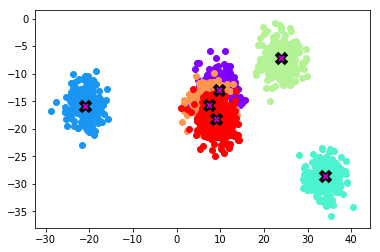

In [33]:
kmeans.plot_data(centroids, data, n_samples)

## K means

In [6]:
k = Kmeans(data, n_clusters)

In [9]:
sess = tf.InteractiveSession()

In [24]:
tf.global_variables_initializer().run()
initial_centroids = k.find_initial_centroids(n_clusters).eval()

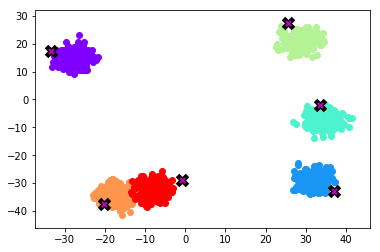

In [25]:
kmeans.plot_data(initial_centroids, data, n_samples)

In [27]:
curr_centroids = tf.Variable(initial_centroids)
nearest_indices = k.assign_to_nearest(curr_centroids)
updated_centroids = k.update_centroids(nearest_indices)
tf.global_variables_initializer().run()

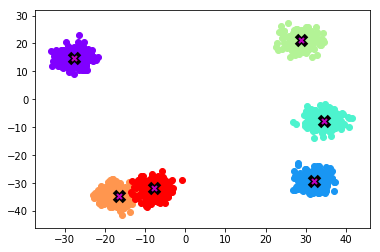

In [28]:
kmeans.plot_data(updated_centroids.eval(), data, n_samples)

In [ ]:
c2 = curr_centroids.assign(updated_centroids).eval()

In [7]:
with tf.Session().as_default(): new_centroids = k.run()

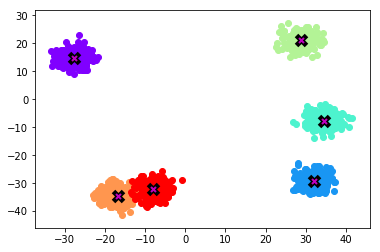

In [8]:
kmeans.plot_data(new_centroids, data, n_samples)

## Mean shift

In [237]:
def gaussian(d, bw):
    return np.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [272]:
def meanshift(data):
    X = np.copy(data)
    for it in range(5):
        for i, x in enumerate(X):
            dist = np.sqrt(((x-X)**2).sum(1))
            weight = gaussian(dist, 2.5)
            X[i] = (np.expand_dims(weight,1)*X).sum(0) / weight.sum()
    return X

In [273]:
%time X=meanshift(data)

CPU times: user 1 s, sys: 8 ms, total: 1.01 s
Wall time: 1.01 s


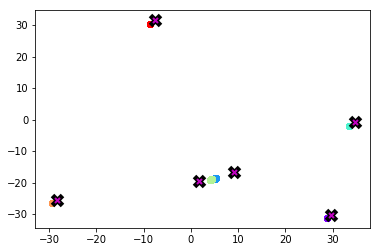

In [274]:
kmeans.plot_data(centroids+1, X, n_samples)

## PyTorch

In [34]:
import torch_utils; reload(torch_utils)
from torch_utils import *

In [35]:
def gaussian(d, bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [275]:
def meanshift(data):
    X = torch.FloatTensor(np.copy(data))
    for it in range(5):
        for i, x in enumerate(X):
            dist = torch.sqrt((sub(x, X)**2).sum(1))
            weight = gaussian(dist, 3)
            num = mul(weight, X).sum(0)
            X[i] = num / weight.sum()
    return X

In [277]:
%time X = meanshift(data).numpy()

CPU times: user 1.38 s, sys: 0 ns, total: 1.38 s
Wall time: 1.38 s


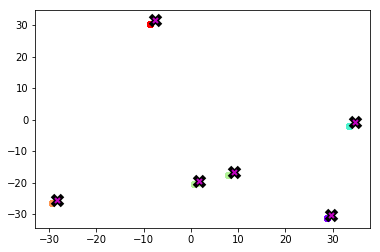

In [217]:
kmeans.plot_data(centroids+1, X, n_samples)

### GPU

In [37]:
def dist_b(a,b):
    return torch.sqrt((sub(a.unsqueeze(0),b.unsqueeze(1))**2).sum(2))

In [38]:
a=torch.rand(2,2)
b=torch.rand(3,2)
dist_b(b, a).squeeze(2)


 0.9036  0.6772  0.9950
 0.5185  0.3260  0.6215
[torch.FloatTensor of size 2x3]

In [39]:
def gaussian(d, bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [40]:
def sum_sqz(a,axis): return a.sum(axis).squeeze(axis)

In [48]:
def meanshift(data, bs=500):
    n = len(data)
    X = torch.FloatTensor(np.copy(data)).cuda()
    for it in range(5):
        for i in range(0,n,bs):
            s = slice(i,min(n,i+bs))
            weight = gaussian(dist_b(X, X[s]), 2)
            num = sum_sqz(mul(weight, X), 1)
            X[s] = div(num, sum_sqz(weight, 1))
    return X

In [49]:
%time X = meanshift(data).cpu().numpy()

CPU times: user 40 ms, sys: 4 ms, total: 44 ms
Wall time: 44.8 ms


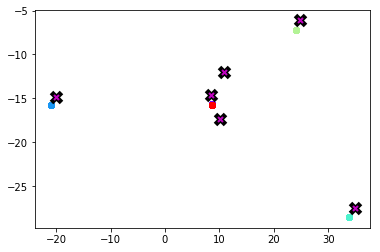

In [50]:
kmeans.plot_data(centroids+1, X, n_samples)

## LSH

In [90]:
from sklearn.neighbors import LSHForest, KDTree

In [81]:
n_clusters=6
n_samples =2500

In [82]:
centroids = np.random.uniform(-35, 35, (n_clusters, 2))
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples)
           for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

In [85]:
nn = LSHForest(n_estimators=1, n_candidates=250, n_neighbors=50)

In [96]:
nn = KDTree(data)

In [97]:
nearest = nn.query(data[:10], 3, False)

In [98]:
nearest

array([[   0,  711, 1901],
       [   1, 1696, 1648],
       [   2, 1526, 1990],
       [   3, 1600,  494],
       [   4, 2442, 2215],
       [   5, 2204, 1018],
       [   6, 1261,  350],
       [   7, 2125, 2206],
       [   8, 2011, 2161],
       [   9,  426, 2190]])

In [99]:
X = torch.FloatTensor(data).cuda()

In [121]:
def meanshift(data, bs=512):
    n = len(data)
    d = np.copy(data)
    X = torch.FloatTensor(d).cuda()
#     nn = LSHForest(n_estimators=1, n_candidates=250, n_neighbors=50)
    for it in range(5):
        d = X.cpu().numpy()
        nn = KDTree(d)
#         nn.fit(d)
        for i in range(0,n,bs):
            s = slice(i,min(n,i+bs))
            nearest = torch.LongTensor(nn.query(d[s], 25, False)).cuda()
            print(nearest.size(), X.size())
            pts =torch.gather(X, 0, nearest)
            weight = gaussian(dist_b(X, X[s]), 2)
            num = sum_sqz(mul(weight, X), 1)
            X[s] = div(num, sum_sqz(weight, 1))
    return X

In [122]:
# %time 
X = meanshift(data).cpu().numpy()

torch.Size([512, 25]) torch.Size([15000, 2])


RuntimeError: Input tensor must have same size as output tensor apart from the specified dimension at /data/users/soumith/miniconda2/conda-bld/pytorch-cuda80-0.1.9_1487349287443/work/torch/lib/THC/generic/THCTensorScatterGather.cu:29

In [48]:
def meanshift(data, bs=500):
    n = len(data)
    X = torch.FloatTensor(np.copy(data)).cuda()
    for it in range(5):
        for i in range(0,n,bs):
            s = slice(i,min(n,i+bs))
            weight = gaussian(dist_b(X, X[s]), 2)
            num = sum_sqz(mul(weight, X), 1)
            X[s] = div(num, sum_sqz(weight, 1))
    return X